Vimos que la API nos devuelve ciertos atributos que son útiles para nutrir el dataset, pero hay otros, que nos resultan interesantes, y no podemos obtenerlos por medio de la API. Para resolver esto, vamos a realizar un Scrapper HTML.

Nos autenticamos con Google Cloud Storage y descargamos el dataset.

In [1]:
project_id = 'cryptic-opus-335323'
bucket_name = 'bdm-unlu'
from google.colab import auth
auth.authenticate_user()
!gsutil cp gs://{bucket_name}/attributes/dataset.csv dataset.csv

Copying gs://bdm-unlu/attributes/dataset.csv...
- [1 files][ 97.5 MiB/ 97.5 MiB]                                                
Operation completed over 1 objects/97.5 MiB.                                     


Leemos el dataset con pandas, a un dataframe, y le agregamos la opción "display.max_colwidth" para que no limite la longitud de los string, y poder ver los permalinks completos.

In [3]:
import pandas as pd
pd.set_option('display.max_colwidth', 150)
data = pd.read_csv("dataset.csv")

Empezemos analizando el primer permalink del dataset

In [10]:
permalink = data.head(1).permalink[0]
permalink

'https://departamento.mercadolibre.com.ar/MLA-1116767893-departamento-venta-3-ambientes-palermo-amenities-cochera-_JM'

Importamos la librería requests para hacer peticiones HTML. Y realizamos una solicitud al permalink obtenido anteriormente y vemos que el código de respuesta es un 200 OK.

In [11]:
import requests

r = requests.get(permalink)

r

<Response [200]>

Y por otro lado, tenemos la primera parte de la respuesta HTML para el inmueble consultado.

In [17]:
r.text[:300]

'\n<!DOCTYPE html>\n<html lang="es-AR">\n<head><link rel="preconnect" href="https://www.google-analytics.com"/><link rel="preconnect" href="https://www.google.com"/><link rel="preconnect" href="https://data.mercadolibre.com"/><link rel="preconnect" href="https://http2.mlstatic.com"/><link rel="preconnec'

Si vemos el código HTML en un navegador, con ayuda de las herramientas para el desarrollador, podremos detectar que la tabla de caracteristicas, esta contenida den un tag DIV, que tiene una clase llamada ui-pdp-specs.

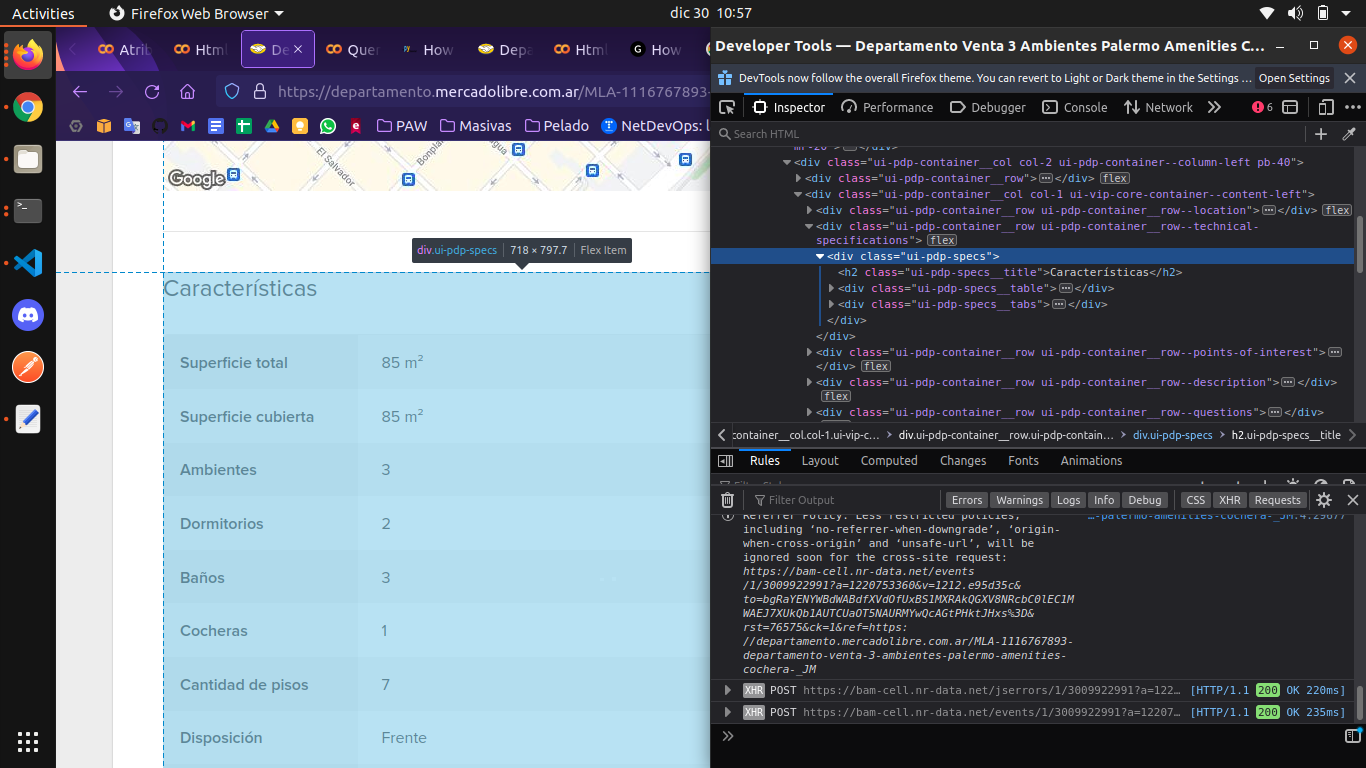

En la siguiente función haicendo uso de la librería BeautifulSoup, parseamos el html, primero buscando el div con la clase mencionada anteriormente. Luego la tabla contenida por este div. Si alguna de estas busquedas arrojara una excepción, sabremos que la tabla, no está en el HTML.

In [13]:
def contains_specs_table(request_text):
  try:
    soup = BeautifulSoup(request_text, 'html.parser')
    div = soup.find_all("div", {"class":"ui-pdp-specs"})[0]
    table = div.find_all("div", {"class":"ui-pdp-specs__table"})[0]
    result = True
  except Exception as e:
    result = False
  return result

Para que verificamos si la tabla está en la respuesta o no? Por 2 motivos.



*   Ocasionalmente el servidor contesta con un desafio Javascript.
*   Algunos permalinks no llevan a la publicación del inmueble sino a una pagina anterior.

Un ejemplo de este ultimo caso, es [este](https://inmuebles.mercadolibre.com.ar/departamentos/venta/propiedades-individuales/#redirectedFromVip) permalink.

Vemos que tiene un botón "ver más", que al clickearlo nos lleva a la publicación del inmueble.
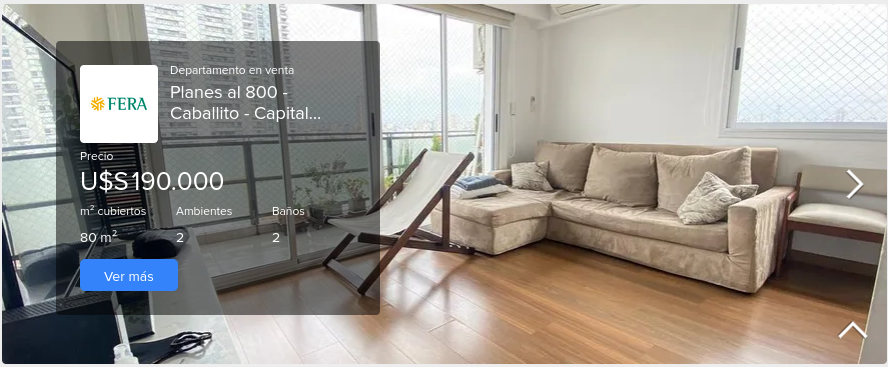



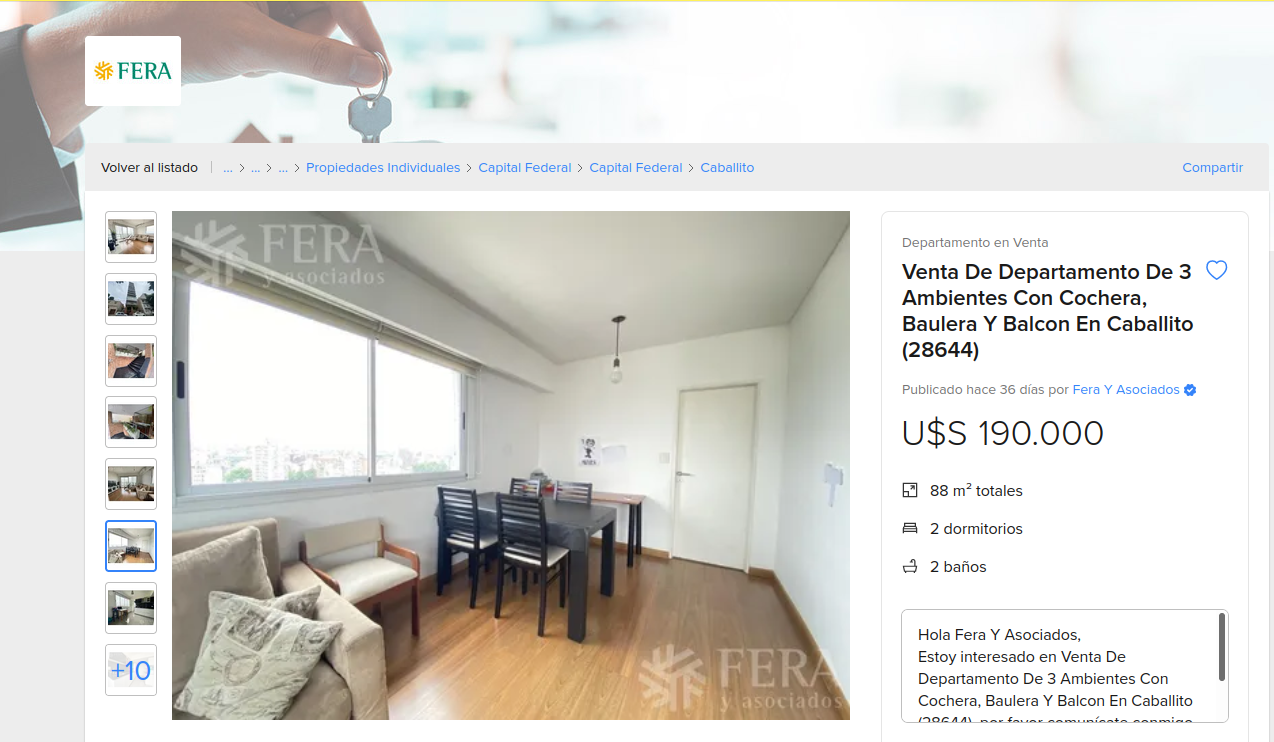

Para resolver este caso, hicimos la siguiente función. Que parsea la respuesta html buscando un tag "a", con una clase determinada, que es la que vimos que contenía el tag utilizado el inspector del navegador.

En caso de encontrarlo, devolvemos el href que contiene este tag, que es el link que efectivamente nos lleva al inmueble deseado.

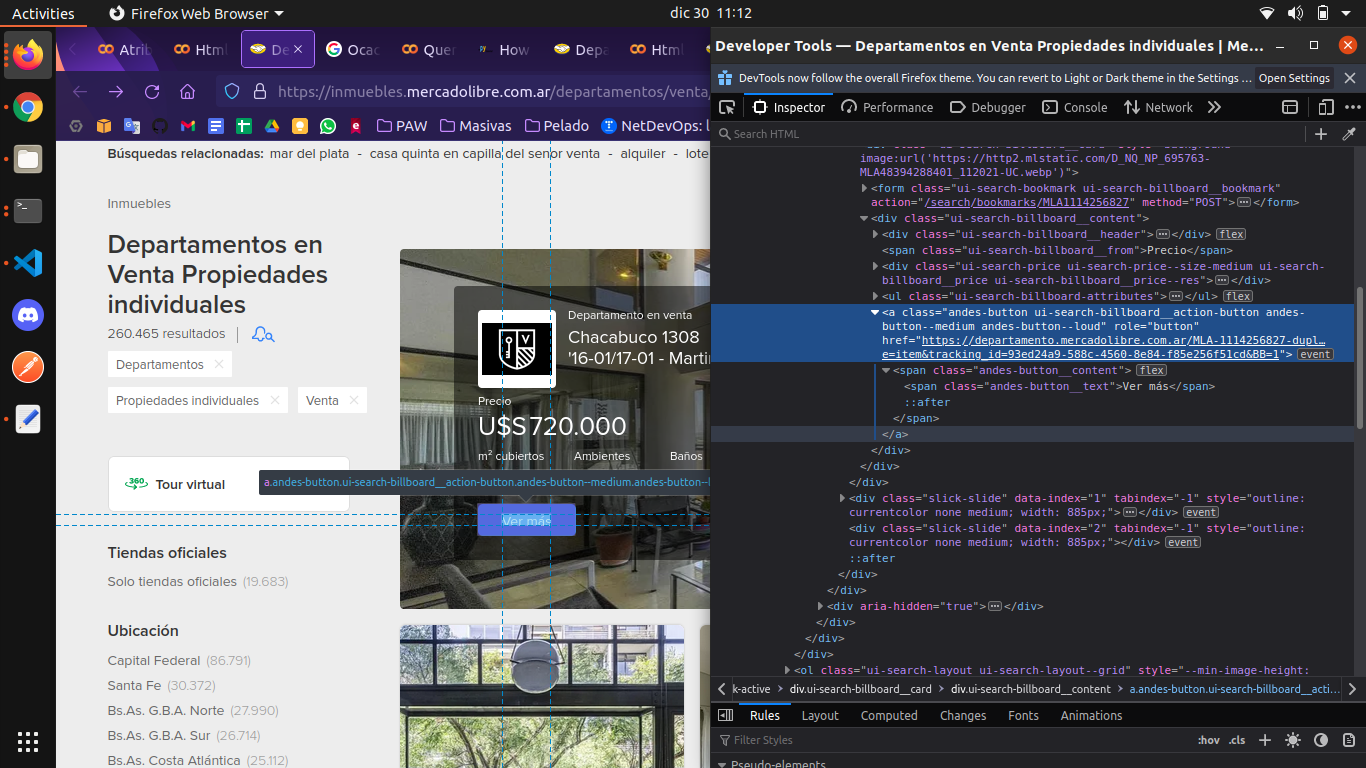

In [12]:
def get_link_see_more_anchor(request_text):
  try:
    soup = BeautifulSoup(request_text, 'html.parser')
    anchor = soup.find_all("a", {"class":"andes-button ui-search-billboard__action-button andes-button--medium andes-button--loud"})[0]
    result = anchor["href"]
  except Exception as e:
    result = None
  return result

El desafío Javascript que contesta el servidor, probablemente se deba a la cantidad de requests que estamos realizando. El servidor intenta sobrecargar al cliente con un código Javascript, para que deje de realizar peticiones.
La manera de solucionarlo que encontramos, es realizando la petición nuevamente.

Relacionado con esto último, hay un gran inconveniente al que nos enfrentamos.
Si iteramos por cada uno de los permalinks, y realizamos las peticiones, estas son efectuadas de forma muy rápida, lo que provoca que MercadoLibre nos banee, y deje de contestarnos las peticiones.

Para solucionar esto, debemos incluir un tiempo de espera entre cada petición. Si este tiempo es de 1 segundo, tardaríamos 20 días en recuperar todos los archivos HTML deseados.

Es necesario que estas requests se realicen single-thread, porque la ip publica de cada uno de los threads, es la misma, por lo que MercadoLibre nos banearía igual, por mas que estemos haciendo las requests en trheads separados.

La solución es utilizar direcciones ip publicas diferentes, para cada una de las peticiones. Esto lo logramos utilizando 12 instancias en Google Cloud Platform.

Utilizando todo lo mostrado anteriormente escribimos un código python, lo dockerizamos, y lo ejecutamos en cada una de estas instancias, logrando hacer las peticiones en 2 horas, almacenando los resultados en Google Cloud Storage.

Cabe destacar que almacenamos el html completo, de cada petición, para utilizarlos en posteriores analisis, y no limitarnos unicamente a la tabla de caracteristicas de los inmuebles. En total, son 12 archivos de 10gb cada uno.

El código fuente de esto que comentamos, se encuentra en el repositorio, en el path html_scrapper/source_code/